# Working With HIRES Data
by Yannick Lecoeuche

## Introduction
[This tutorial and included python files are written using Python 3. If you are using Python 2, the only changes that should be necessary are putting parentheses around print statements in the cells. Enjoy!]

In this tutorial we will show you how to open HIRES data, display images, and graph one-dimensional spectrums of the information kept in the image. We have supplied three stellar spectra and three corresponding wavelength solutions with this notebook, and we will begin by determining the minimum and maximum wavelengths represented in the spectrum and then attempting to recreate some sample graphs of the spectrum.

First, we must import the necessary programming components:

In [319]:
%matplotlib inline
import numpy as np
from astropy.io import fits as pf
import matplotlib
from matplotlib import pyplot as plt
import lmfit
from lmfit import minimize, Parameters, report_fit, fit_report
from IPython.display import Image

Among these imports includes the fits program, which allows us to easily read HIRES files in the format given, and pyplot, so we can represent the data given in our spectra. The ".fits" files we are working with contain a lot of information, and the fits program allows us to easily access the parts of that information we need. For instance, we will use the fits program to access our spectra (rj122.97.fits), and then dislay image information coded in the fits file:

In [320]:
spectrum_r = pf.open('rj122.97.fits')
spectrum_r.info()

Filename: rj122.97.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     722   (4021, 16)   float32   


The "r" in our file name is due to the fact that the spectrum we opened only covers one third of the total wavelength range. The other two spectrums we will call have the tags "b" and "i".

## Displaying the Spectrum

From the information above we can see that this file contains a single image of type "PrimaryHDU". This is what we wanted to see, however, a problem becomes apparent upon further inspection. If you look in the "Dimensions" section, you may notice that the axes differ by a large factor. Attempting to plot an image with the x dimension so much larger than the y dimension gives an result like this:

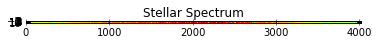

In [321]:
image_r = spectrum_r[0].data
plt.imshow(image_r)
plt.title('Stellar Spectrum')

As you can see, using the .data function gives us just the parts of the file that make up the image itself. Notice that we added the familiar "r" tag to the image variable as well.

The difference between the axes is indeed too large. We can't get much visual information from what appears to be a one dimensional line. To remedy this problem, we can add "aspect = 'auto'" as an argument in our plot function. This simply adjusts the output of the plot function so that the axes are sized similarly.

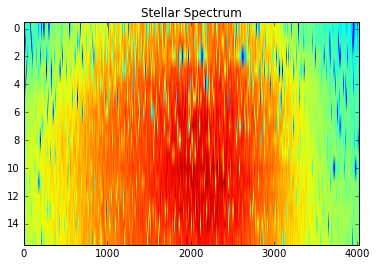

In [322]:
image_r = spectrum_r[0].data
plt.imshow(image_r, aspect = 'auto')
plt.title('Stellar Spectrum')

Much better! This is an image that may look more familiar to you. If not, what we're looking at are the brightness levels of our star at different wavelengths. The information is encoded so that it appears 2-dimensional, but really each horizontal line going left to right across the graph represents a set of increasing wavelength values. This will make more sense as we start analyzing the information. For now, it would be good to know that each pixel in the image represents a wavelength, with the lowest wavelength in the top left corner and the highest in the bottom right.

## Plotting Spectral Lines

Now that we have our spectrum, we can analyze the information inside it most easily by turning parts of it into 1D brightness/wavelength graphs. In order to get our 1D graph from this 2D image, we need to select a single pixel line from the 16 avaliable in the y-axis (remember, we know that the dimensions are 16 by 4021 from looking at the file info). Let's plot line ten in the spectrum:

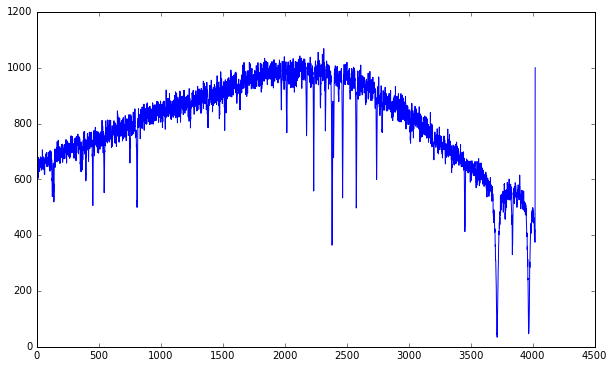

In [323]:
plt.figure(figsize = (10, 6))
plt.plot(image_r[10])

Terrific! There are some clearly visible dips and peaks in this spectrum. The x-axis, however, isn't much use to us when represented in pixels. We want to know which wavelengths the dips and peaks in our graph correspond to, so we need to match the pixels on the x-axis to the wavelengths by using the wavelength solution.

First we call up the wavelength solution, and assign the wavelength values to an array:

In [324]:
wavelength_r = pf.open('keck_rwav.fits')
wave_values_r = wavelength_r[0].data

Since the wavelength solution is specific to our "r" spectrum, we do not need to check that the dimensions are the same. You can continue to use these three wavelength solutions for  corresponding "r", "b", and "i" HIRES spectrums you download in the future. Now that we have all our wavelength values, we can assign them to the x-axis (where our pixels used to be) and our spectrum values to the y-axis, and then graph them. While we're at it, we'll also label the x-axis with the proper units:

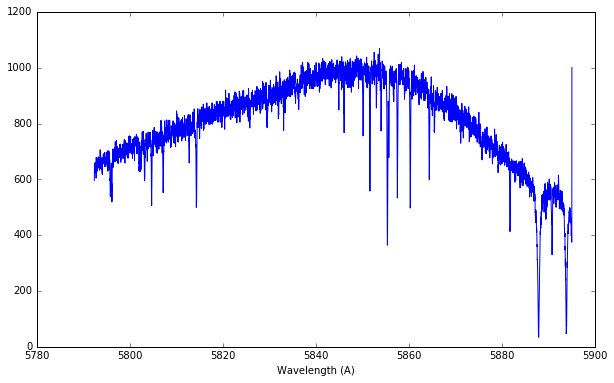

In [325]:
x = wave_values_r[10]
y = image_r[10]
plt.figure(figsize = (10,6))
plt.plot(x,y)
plt.xlabel('Wavelength (A)')

This looks almost like what we want! It seems we may have graphed too large of a wavelength range to pick out particular features. For an idea of what types of spectral features we hope to pick out, we can take a look at some sample graphs of this spectrum and attempt to recreate them ourselves.

![Example Spectrums](SampleGraphs.png)

These graphs use much smaller wavelength ranges than we just did. Let's try and adjust our own range to match some of these images. It would prudent to first determine the total scope of wavelengths represented in our spectrum. We may find that some of the example graphs are out of our range. We can determine the lowest and highest wavelengths represented by looking at the first value on the 0th line (top left corner) and the last value on the 15th line (bottom right corner):

In [326]:
print (wave_values_r[0, 0])
print (wave_values_r[15, 4020])

4976.64794645
6421.36429021


It looks like our range goes from 4976 Angstroms to 6421 Angstroms. So of the six example graphs, we can only attempt to replicate graphs 3 through 5. That's alright though, because we have included the two CCD's that complete the full wavelength spectrum available. We will open these and their wavelength solution counterparts now and check their dimensions:

In [327]:
spectrum_b = pf.open('bj122.97.fits')
wavelength_b = pf.open('keck_bwav.fits')
wave_values_b = wavelength_b[0].data
spectrum_b.info()

spectrum_i = pf.open('ij122.97.fits')
wavelength_i = pf.open('keck_iwav.fits')
wave_values_i = wavelength_i[0].data
spectrum_i.info()

Filename: bj122.97.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     722   (4021, 23)   float32   
Filename: ij122.97.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     722   (4021, 10)   float32   


It's good that we checked the dimensions of the two other CCD's since they have different total numbers of lines. With this information, we can now check the wavelength boundaries of the two CCD's.

In [328]:
print (wave_values_b[0, 0])
print (wave_values_b[22, 4020])

print (wave_values_i[0,0])
print (wave_values_i[9, 4020])

3642.93
4794.53
6543.15071655
7989.83665355


Alright, now we know the entire spectrum. As you may have noticed, the ends of the spectrums do not perfectly overlap with each other. This will not affect our ability to recreate the sample graphs.

It is time to recreate the first spectrum of the six shown. The first step is to examine the boundaries on the graph given. They appear to go from 3958 to 3978. Plugging in test values to wave_values_b will eventually reveal that the 3958 and 3978 Angstrom marks correspond closest to the 1772nd and 2946th pixels (respectively) on the seventh line.

In [329]:
print (wave_values_b[7, 1772])
print (wave_values_b[7, 2946])

3958.01
3978.0


Play around with new values in the above cell (keeping in mind the boundaries on the CCD) until you get a good idea of how the pixels and wavelengths correspond to each other. Once you feel you have it, you can save a lot of guesswork using this set of tables from the Keck Observatory website:

### HIRES blue chip (b):

Wavelength range (Ang) per order:

    order    min wavelength  max wavelength
********************************************
       0       3642.9314       3706.8240
       1       3680.7625       3745.3972
       2       3719.7527       3784.8733
       3       3759.0449       3825.1785
       4       3799.5925       3866.3210
       5       3840.8242       3908.3191
       6       3883.0046       3951.3738
       7       3926.1953       3995.2864
       8       3970.2517       4040.0691
       9       4015.3870       4086.0713
      10       4061.5300       4133.0503
      11       4108.7329       4181.1284
      12       4157.0581       4230.3276
      13       4206.5337       4280.7046
      14       4257.1963       4332.2949
      15       4309.0938       4385.1489
      16       4362.2773       4439.2959
      17       4416.7856       4494.8013
      18       4472.6772       4551.7104
      19       4530.0059       4610.0815
      20       4588.8154       4669.9697
      21       4649.1797       4731.4287
      22       4711.1470       4794.5278
      

### HIRES "Middle" or "iodine" chip (r)
      
Wavelength range (Ang) per order:

    order    min wavelength  max wavelength
********************************************
       0       4976.6479       5064.7810
       1       5047.7274       5137.1426
       2       5120.8688       5211.6012
       3       5196.1628       5288.2490
       4       5273.7059       5367.1835
       5       5353.6004       5448.5086
       6       5435.9548       5532.3342
       7       5520.8845       5618.7774
       8       5608.5123       5707.9627
       9       5698.9690       5800.0225
      10       5792.3939       5895.0982
      11       5888.9355       5993.3403
      12       5988.7527       6094.9099
      13       6092.0150       6199.9788
      14       6198.9040       6308.7312
      15       6309.6143       6421.3643
      

### HIRES Red chip (i)
      
Wavelength range (Ang) per order:

    order    min wavelength  max wavelength
********************************************
       0       6543.1507       6658.9463
       1       6666.6266       6784.5357
       2       6794.8600       6914.9490
       3       6928.1312       7050.4689
       4       7066.7430       7191.4008
       5       7211.0231       7338.0753
       6       7361.3265       7490.8502
       7       7518.0383       7650.1142
       8       7681.5775       7816.2897
       9       7852.4000       7989.8367

Now that we have our boundaries for the first graph, we can create our data arrays and plug in our values to see if we get a similar graph using our pixel choices. We will display the sample graph right below:

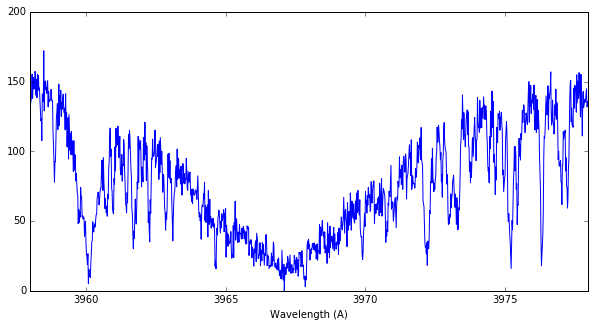

In [330]:
image_b = spectrum_b[0].data
image_i = spectrum_i[0].data

x = wave_values_b[7, 1772:2946]
y = image_b[7, 1772:2946]
plt.figure(figsize = (10,5))
plt.plot(x,y)
plt.axis([3958, 3978, 0, 200])
plt.xlabel('Wavelength (A)')

![Graph 1](Graph1.jpg)

Looks great! Now that you know how to find the proper boundaries, and how to use them in a graph, we can skip some steps replicating the rest of the graphs:

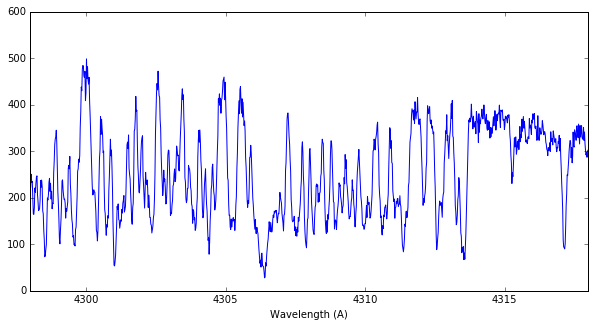

In [331]:
x = wave_values_b[14, 2100:3195]
y = image_b[14, 2100:3195]
plt.figure(figsize = (10,5))
plt.plot(x,y)
plt.axis([4298, 4318, 0, 600])
plt.xlabel('Wavelength (A)')

![Graph 2](Graph2.jpg)

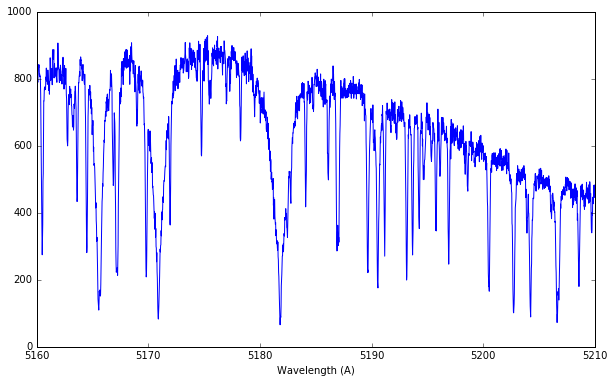

In [332]:
x = wave_values_r[2, 1654:3942]
y = image_r[2, 1654:3942]
plt.figure(figsize = (10,6))
plt.plot(x,y)
plt.axis([5160, 5210, 0 , 1000])
plt.xlabel('Wavelength (A)')

![](Graph3.jpg)

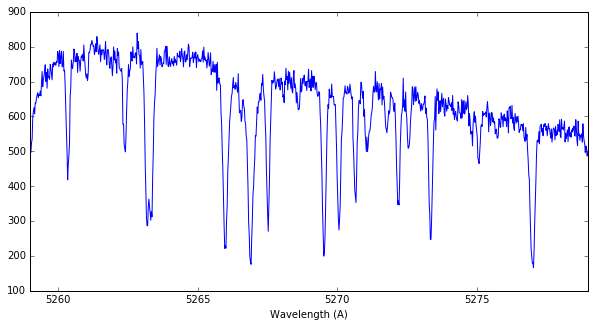

In [333]:
x = wave_values_r[3, 2664:3580]
y = image_r[2, 2664:3580]
plt.figure(figsize = (10, 5))
plt.plot(x,y)
plt.axis([5259, 5279, 100, 900])
plt.xlabel('Wavelength (A)')

![](Graph4.jpg)

Our first issue! These two graphs don't look alike. This confirms something that you may have started to suspect by looking very closely at the previous graphs: they are not the same star. 

The two graphs we just produced are different because the metallicity of the two stars are different. The similarity between two different Sun-like stars is still strong, however, so using a different star's spectral readings is still an adequate way of testing whether or not your own readings are correctly programmed.

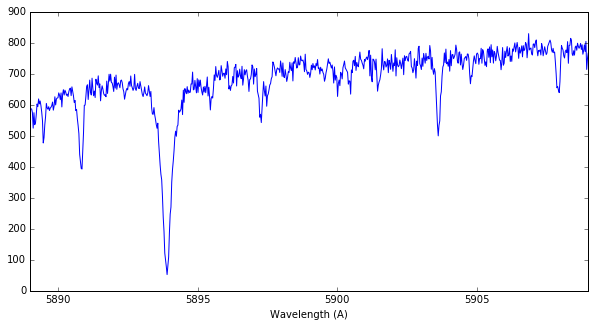

In [334]:
x = wave_values_r[11, 3:728]
y = image_r[11, 3:728]
plt.figure(figsize = (10,5))
plt.plot(x,y)
plt.axis([5889, 5909, 0, 900])
plt.xlabel('Wavelength (A)')

![](Graph5.jpg)

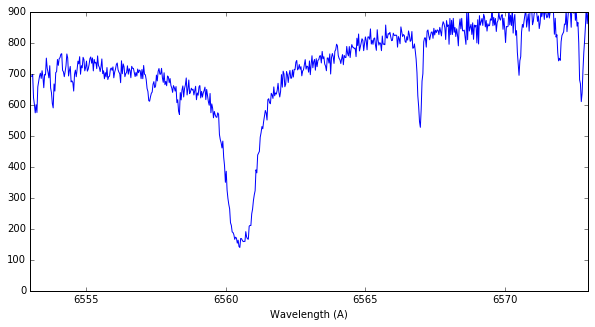

In [335]:
x = wave_values_i[0, 321:979]
y = image_i[0, 321:979]
plt.figure(figsize = (10,5))
plt.plot(x,y)
plt.axis([6553, 6573, 0, 900])
plt.xlabel('Wavelength (A)')

![](Graph6.jpg)

Great! Our graphs have turned out how we wanted them, and now with a few minor changes to the code in this program, you can make similar graphs for CCD's from other stars! There was, however, a fair amount of busywork in explaining the spectrum and how to analyze it correctly. Now that we understand what we're aiming for, we can create a code that requires far fewer steps to get the same results.

## Making the Code Self-Sufficient

The code that we have written up to this point has worked as we wanted it to, but was a little bulky overall. We had to find the pixels corresponding to the wavelength values and graph them six individual times, as well as open up all the files separately and configure them to the correct places. This method, while helpful for learning, is time-consuming, and only worked because the wavelength ranges we used were conveneient.

Say, for example, that we wanted to view the spectral line of the star from 6300 to 6320 Angstroms. A quick check of the wavelength chart given earlier will show that these values exist in two separate orders, so our previous code would not be sufficient to correctly graph the spectrum. This break in ranges could even span across two different CCD's, requiring even more code to graph properly. The point of this section is to formulate an easy-to-use portion of code where one can easily choose a spectrum and values to graph without having to worry about boundaries between orders and CCD's.

### Finding the Wavelength Placement

What we want to do first is determine which file, order, and pixel values correspond to our start and end wavelengths, separately. Let's start by searching through the files to see if the start and end wavelengths are within their boundaries.

In [336]:
start_value = 4500 
wavelength_range = 600

sections = ['b', 'r', 'i'] #so we can cycle through the files and save space
end_value = start_value + wavelength_range

for i in range (3):        #cycling through files and getting their dimensions
    wavelength = eval('wave_values_' + sections[i])
    image = eval('image_' + sections[i])
    order_max = wavelength.shape[0]
    wavelength_max = wavelength.shape[1]
    
    if wavelength[0, 0] <= start_value < wavelength[order_max - 1, wavelength_max - 1]: #finding the start value file
        start_file = i
        
    if wavelength[0, 0] <= end_value < wavelength[order_max - 1, wavelength_max - 1]: #finding the end value file
        end_file = i 
        
file_range = end_file - start_file
print (file_range)

1


The code above should be fairly understandable, and with it we now know how far apart the two values are in terms of files. The "file_range" value of 1 tells us that the start and end wavelengths are in adjacent CCD files. By adding more loops into the code, we can do a similar search to determine many orders and pixels apart the two values are.

In [337]:
end_order = 0    #calibration so as not to return error
start_order = 0
end_wavelength = 0
start_wavelength = 0

for n in range(order_max):                                                   #checking every order in a file
    if wavelength[n, 0] <= start_value < wavelength[n, wavelength_max - 1]:  #finding the start value order
        start_order = n 
        for m in range(wavelength_max):                    #checking every wavelength in an order
            if abs(start_value - wavelength[n, m]) < .02:  #finding the start value pixel within .02 angstroms
                start_wavelength = m
                            
for n in range(order_max):                                                  #same as top four, but for end value
    if wavelength[n, 0] <= end_value < wavelength[n, wavelength_max - 1]:
        end_order = n
        for m in range(wavelength_max):
            if abs(end_value - wavelength[n, m]) < .02:
                end_wavelength = m
                    
order_range = end_order - start_order
wavelength_range = end_wavelength - start_wavelength

This set of code won't return any valuable information, since it is not looping through all the files, but it is a good example of how one would find the desired order and wavelength values in a file. Once you have values for the file_range, order_range and wavelength_range, you can set up three main cases for your resultant graph.

### Plotting the Complete Wavelength Range

#### 1.) file_range = 0, order_range = 0
    
This means that the two values you want are in the same order in the same file. This is the easiest to plot, you just need to set the boundaries of the graph to start_wavelength and end_wavelength
    
#### 2.) file_range = 0, order_range != 0

In this case, your two values are in the same file, but span more than one order. You need to graph from the start value to the end of its order, the beginning of the end value's order to the end value, and any orders in between.

#### 3.) file_range != 0

The two values are in different files. In this case you would need to graph from the start value to the end of the file, the beginning of the next file to the end value, and any files in between.

### Using the Complete Code

As you can guess at this point, the complete code we get once we put all this together can be quite lengthy. Even with all that we have so far, there are several other cases that are necessary to address if we want to make the code completely robust. For instance, the user may choose start and/or end wavelengths that are between orders and files, or that are completely outside the spectrum range. We want to set up the code so that the user always gets a result, regardless of whether or not their range choice is practical or thought out.

Below is the full code in the form of a function, so we can call it later without looking at a huge mess of lines each time. Note how it takes only the wavelength and range desired, and how it deals with special cases by assigning the start_value and end_value to the closest corresponding values in the CCD's.

In [338]:
def spectral_plot(wav, rang):
    start_value = wav
    wavelength_range = rang

    wave_values_b = pf.open('keck_bwav.fits')[0].data
    wave_values_r = pf.open('keck_rwav.fits')[0].data
    wave_values_i = pf.open('keck_iwav.fits')[0].data

    sections = ['b', 'r', 'i']
    end_value = start_value + wavelength_range
    
    fig = plt.figure(figsize = (10,5))

    print ('Any empty sections in the graph are not covered in the spectrum.')  
    
    for i in range (3):        #Cycling through files
        wavelength = eval('wave_values_' + sections[i])
        image = eval('image_' + sections[i])
        order_max = wavelength.shape[0]
        wavelength_max = wavelength.shape[1]
    
        if i == 0:      #if start value is below total range, reassign values
            if start_value < wavelength[0,0]:
                start_file = 0
                start_order = 0
                start_wavelength = 0
                
        if i == 2:      #if end value is above total range, reassign values
            if end_value > wavelength[order_max - 1,wavelength_max - 1]:
                end_file = 2
                end_order = order_max - 1
                end_wavelength = wavelength_max - 1

    
        if wavelength[0, 0] <= start_value < wavelength[order_max - 1, wavelength_max - 1]: #if start value is in file
            start_file = i
            for n in range(order_max):
                if wavelength[n, 0] <= start_value < wavelength[n, wavelength_max - 1]: #if start value is in order
                    start_order = n
                    for m in range(wavelength_max):   #if start value is within range of pixel
                        if abs(start_value - wavelength[n, m]) < .02:
                            start_wavelength = m
            for n in range(order_max - 1):
                if wavelength[n, wavelength_max - 1] <= start_value < wavelength[n+1,0]: #if start value is between orders, reassign
                    start_order = n + 1
                    start_wavelength = 0
                        
        if wavelength[0, 0] <= end_value < wavelength[order_max - 1, wavelength_max - 1]:  #if end value is in file
            end_file = i
            for n in range(order_max):
                if wavelength[n, 0] <= end_value < wavelength[n, wavelength_max - 1]: #if end value is in order
                    end_order = n
                    for m in range(wavelength_max):
                        if abs(end_value - wavelength[n, m]) < .02:  #if end value is within range of pixel
                            end_wavelength = m
            for n in range(order_max - 1):
                if wavelength[n, wavelength_max - 1] <= end_value < wavelength[n+1,0]:   #if end value between orders, reassign
                    end_order = n
                    end_wavelength = wavelength_max - 1

    for i in range (2):
        wavelength1 = eval('wave_values_' + sections[i])
        image1 = eval('image_' + sections[i])
        wavelength2 = eval('wave_values_' + sections[i+1])
        image2 = eval('image_' + sections[i+1])
        order_max1 = wavelength1.shape[0]
        wavelength_max1 = wavelength1.shape[1]
        order_max2 = wavelength2.shape[0]
        wavelength_max2 = wavelength2.shape[1]
    
        if wavelength1[order_max1-1, wavelength_max1-1] <= start_value < wavelength2[0, 0]: #if start value is between files, reassign
            start_file = i + 1
            start_order = 0
            start_wavelength = 0
        
        if wavelength1[order_max1-1, wavelength_max1-1] <= end_value < wavelength2[0, 0]: #if end value is between files, reassign
            end_file = i
            end_order = order_max1 - 1
            end_wavelength = wavelength_max1 - 1
    
                
    file_range = end_file - start_file
    order_range = end_order - start_order

    if file_range == 0 and order_range == 0:   #start and end in same orders
        wavelength = eval('wave_values_' + sections[start_file])
        image = eval('image_' + sections[start_file])
        x = wavelength[start_order, start_wavelength:end_wavelength]
        y = image[start_order, start_wavelength:end_wavelength]
        plt.plot(x,y, figure = fig)
        axes = plt.gca()
        axes.set_xlim(start_value, end_value)
        plt.xlabel('Wavelength (A)', figure = fig)
        
    if file_range == 0 and order_range != 0:   #start and end in different orders
        wavelength = eval('wave_values_' + sections[start_file])
        image = eval('image_' + sections[start_file])
        x_start = wavelength[start_order, start_wavelength:]
        y_start = image[start_order, start_wavelength:]
        x_end = wavelength[end_order, :end_wavelength]
        y_end = image[end_order, :end_wavelength]
        plt.plot(x_start, y_start, figure = fig)
        plt.plot(x_end, y_end, figure = fig)
        
        for i in range(start_order + 1, end_order):  #plot orders between
            x = wavelength[i]
            y = image[i]
            plt.plot(x,y, figure = fig)
        
        axes = plt.gca()
        axes.set_xlim(start_value, end_value)
        plt.xlabel('Wavelength (A)', figure = fig)
    
    if file_range != 0:   #start and end in different files
        wavelength1 = eval('wave_values_' + sections[start_file])
        image1 = eval('image_' + sections[start_file])
        order_max1 = wavelength1.shape[0]
        wavelength2 = eval('wave_values_' + sections[end_file])
        image2 = eval('image_' + sections[end_file])
        x_start = wavelength1[start_order, start_wavelength:]
        y_start = image1[start_order, start_wavelength:]
        x_end = wavelength2[end_order, :end_wavelength]
        y_end = image2[end_order, :end_wavelength]
        plt.plot(x_start, y_start, figure = fig)
        plt.plot(x_end, y_end, figure = fig)
    
        for i in range(start_order + 1, order_max1):
            x = wavelength1[i]
            y = image1[i]
            plt.plot(x,y, figure = fig)
        
        for l in range(0, end_order):
            x = wavelength2[l]
            y = image2[l]
            plt.plot(x,y, figure = fig)
        
        for s in range(start_file + 1, end_file):    #plot files between
            wavelength = eval('wave_values_' + sections[s])
            image = eval('image_' + sections[s])
            order_max = wavelength.shape[0]
            for t in range(0, order_max):
                x = wavelength[t]
                y = image[t]
                plt.plot(x,y, figure = fig)
    
        axes = plt.gca()
        axes.set_xlim(start_value, end_value)
        plt.xlabel('Wavelength (A)', figure = fig)

Alright, you made it through! The real test is now to try it out. Using the wavelength chart as a reference, try calling the function for different wavelengths and ranges to see what results you get. We have it set currently to graph the entire spectrum range. 

Any empty sections in the graph are not covered in the spectrum.


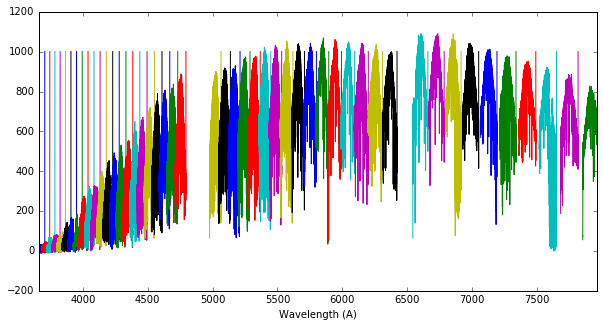

In [339]:
spectral_plot(3660, 4300)

## The Blaze Function

The function works! Something you may have noticed while playing around with ranges is that each order has a curved slope, and that the edges of connecting orders don't align correctly. For instance, look at this image of two orders that overlap in the "r" file.

Any empty sections in the graph are not covered in the spectrum.


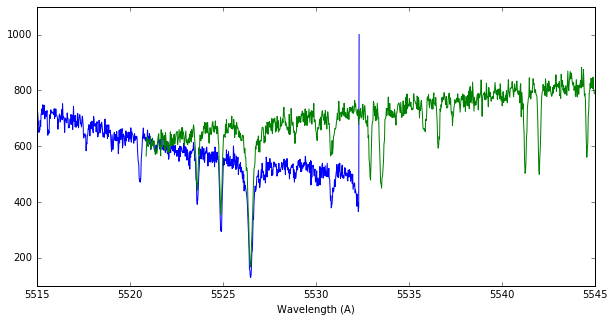

In [340]:
spectral_plot(5515, 30)

The two lines should merge into one, but they don't. This is actually because of the curved shape of each order, a curve that is known as the "blaze function." The KECK telescope measure stellar spectrums using an echelle grating, where each slit in the grating becomes an order in the CCD. The curve is a result of light interference between the slits, and can be approximated as a squared sine function. 

The next step in this tutorial is to remove the blaze function, so we can get seamless, normalized plots of our stellar spectrum. First we need to figure out what our blaze function really looks like. Let's call up an individual order:

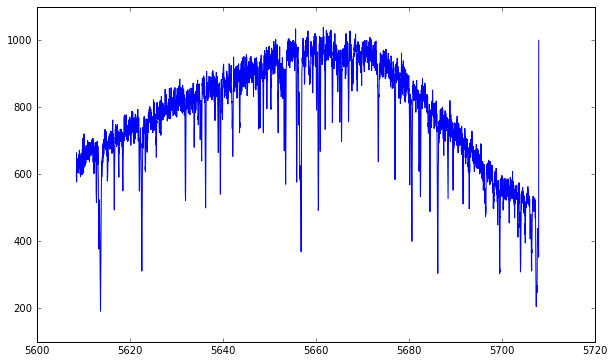

In [341]:
x = wave_values_r[8]
y = image_r[8]

plt.figure(figsize = (10,6))
plt.plot(x, y)

The curve that the order follows can also be fit fairly closely by a polynomial curve. Indeed, this is a much easier curve to fit our data to, as the numpy package includes a function specifically for this purpose. To get our data prepared for the curve fit, we center the curve around x = 0 and normalize it so that its max y-value is one.

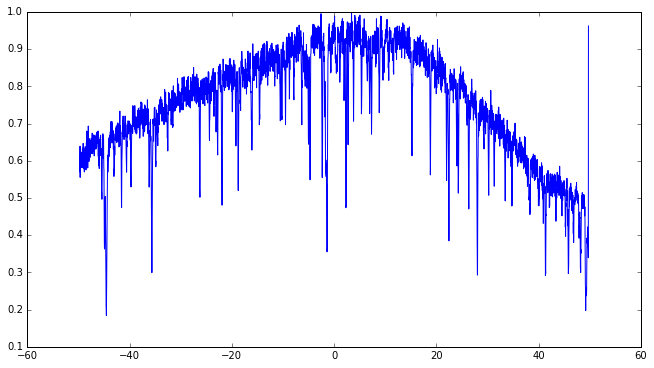

In [342]:
x = wave_values_r[8]
y = image_r[8]

wavelength_range = max(x) - min(x)
wave_center = x - min(x) - wavelength_range/2.
norm_spectrum = y/max(y)

plt.figure(figsize = (11,6))
plt.plot(wave_center, norm_spectrum)

As you can see, our line is unchanged aside from the x and y boundaries. Now we call the "polyfit" function. The first two arguments are our new x and y axes, and the third argument represents the order of the polynomial fit, which we've chosen as 2. Since the polyfit function returns an array of coefficients of the polynomial, we use "poly1d" in the next line to create the polynomial function. Now we can plot the function against our data.

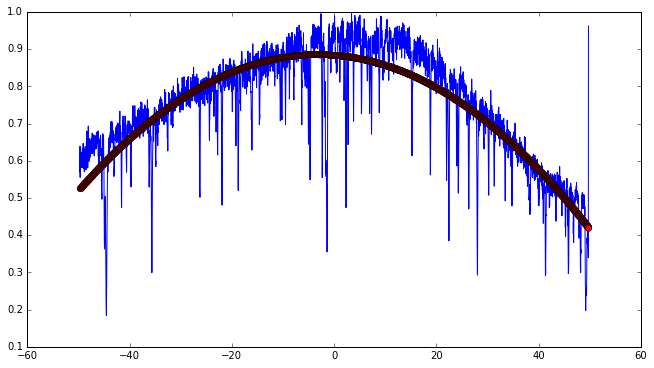

In [343]:
coef = np.polyfit(wave_center, norm_spectrum, 2)

curve_fit = np.poly1d(coef)

plt.figure(figsize = (11,6))
plt.plot(wave_center, norm_spectrum)
plt.plot(wave_center, curve_fit(wave_center), "ro")

The fit is pretty good! What's important to remember is that not all trends in the curve can be attributed to the blaze curve. We can achieve a very strong fit by raising the polynomial value, but it won't resemble a sine squared function and may erase important information in the spectrum.

For the final part, we need to normalize our spectrum, and then put it back in its original wavelength area. We can do this by reintroducing x in our plot function, and by dividing our data by the line we just fit to it

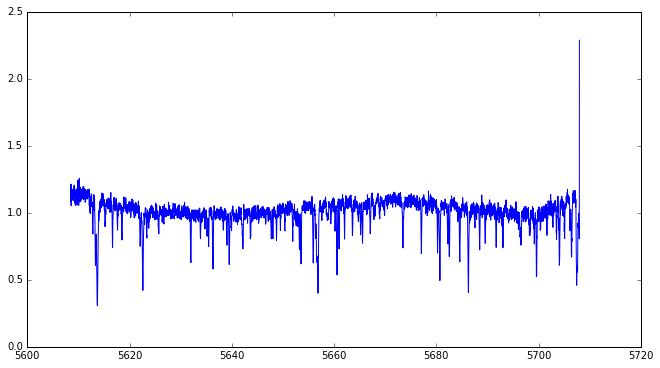

In [344]:
plt.figure(figsize = (11,6))
plt.plot(x, norm_spectrum/curve_fit(wave_center))

We have our normalized spectrum order! You may have to fiddle around with the y-axis to get a nicer image, as the measurement error at the end of the spectrum has offset the plot function's auto-scaling. We also will introduce a section later to remove sharp, erroneous spikes such as this one. 

Now we can introduce a function to loop through all the orders and normalize them.

In [345]:
for i in range (3):
    wavelength = eval('wave_values_' + sections[i])
    image = eval('image_' + sections[i])
    order_max = wavelength.shape[0]
    wavelength_max = wavelength.shape[1]
    
    for s in range(order_max):
        wavelength_range = max(wavelength[s]) - min(wavelength[s])
        wave_center = wavelength[s] - min(wavelength[s]) - wavelength_range/2.
        norm_spectrum = image[s]/max(image[s])
        
        coef = np.polyfit(wave_center, norm_spectrum, 5)

        curve_fit = np.poly1d(coef)
        
        image[s] = norm_spectrum/curve_fit(wave_center)

Now all of our orders should be corrected for the blaze function! Let's try once more to graph the overlapping orders from the beginning of this section.

Any empty sections in the graph are not covered in the spectrum.


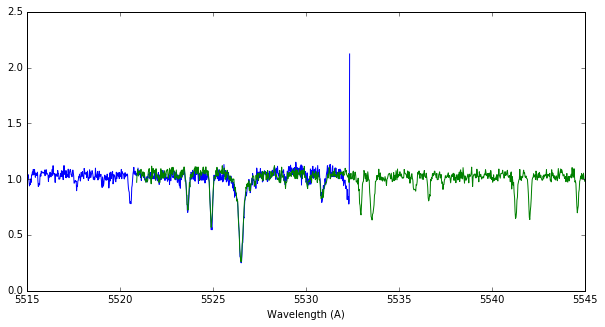

In [346]:
spectral_plot(5515, 30)

Much better! The fit isn't perfect, likely due to the polynomial approximation we made. It is, however, a large improvement, and now our "spectral_plot" function should work within any given range.

Included in this notebook are two Python files:

##### spectral_plot(wav, rang):
a separate version of the code we looked at earlier that can be called quickly from a command prompt. Removes the blaze function from all the files, then plots the part of the spectrum specified by the two arguments (start wavelength and range).


##### six_image(b_file, r_file, i_file): 
given the three files in a spectrum, this program returns the six plots from the example image that we recreated earlier in the tutorial. These images contain important information about the star, and so are made easier to access through this program.

## Moving on to New Data

Well done! You've learned the basics on how stellar spectrums are accessed, searched through, and normalized. Using your newly gained knowledge and the included python programs, you should now be able to analyze new stellar spectrums on your own.

In order to work on a new spectrum, you need to:

1.) Download new CCD's and move them to your notebook folder. (Don't bother downloading new wavelength solutions, the ones attached should work for all HIRES CCD's within one pixel, or .02 Angstroms)

2.) Change the file names called in the program to the names of the new spectrum that you have downloaded. Again, the "b", "r", or "i" at the start of each file name should tell you which files correspond to which variables.

Once that is done, you should be all set to analyze your own data! Good luck!